In [1]:
from pybit.unified_trading import HTTP
import time

from get_candels import get_candels
from calculate_ta_indicators import calculate_ta_indicators
from patterns import patterns

from testing_robot import robot

from optimizer import optimization

from united_dfs import united_dfs
import matplotlib.pyplot as plt
import mplfinance as mpf

import pandas as pd
import numpy as np
import math

from config import api_key, secret
from pybit.unified_trading import HTTP

from ta_strategies import MAKD_Strategy, RSI_Strategy

from copy import deepcopy

e:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
opt = optimization(intervals = [60], limit = 1000, category = "spot", symbol = "BTCUSDT", indicators = [MAKD_Strategy, RSI_Strategy], backtest = False, TP = True, SL=True)
opt.get_data()
s = opt.optimize(n_trials=1000)


In [14]:
s.best_params

{'fastperiod_60': 20,
 'slowperiod_60': 21,
 'signalperiod_60': 29,
 'rsi_60': 25,
 'loss': -2,
 'revenue': 1}

In [15]:
s.best_value

7.785058220000006

In [20]:
opt.mistakes/opt.transactions * 100

50.0

In [16]:
buy = pd.DataFrame(opt.buy)
sell = pd.DataFrame(opt.sell)

buy.set_index('time', inplace=True)
sell.set_index('time', inplace=True)

e:\Python310\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


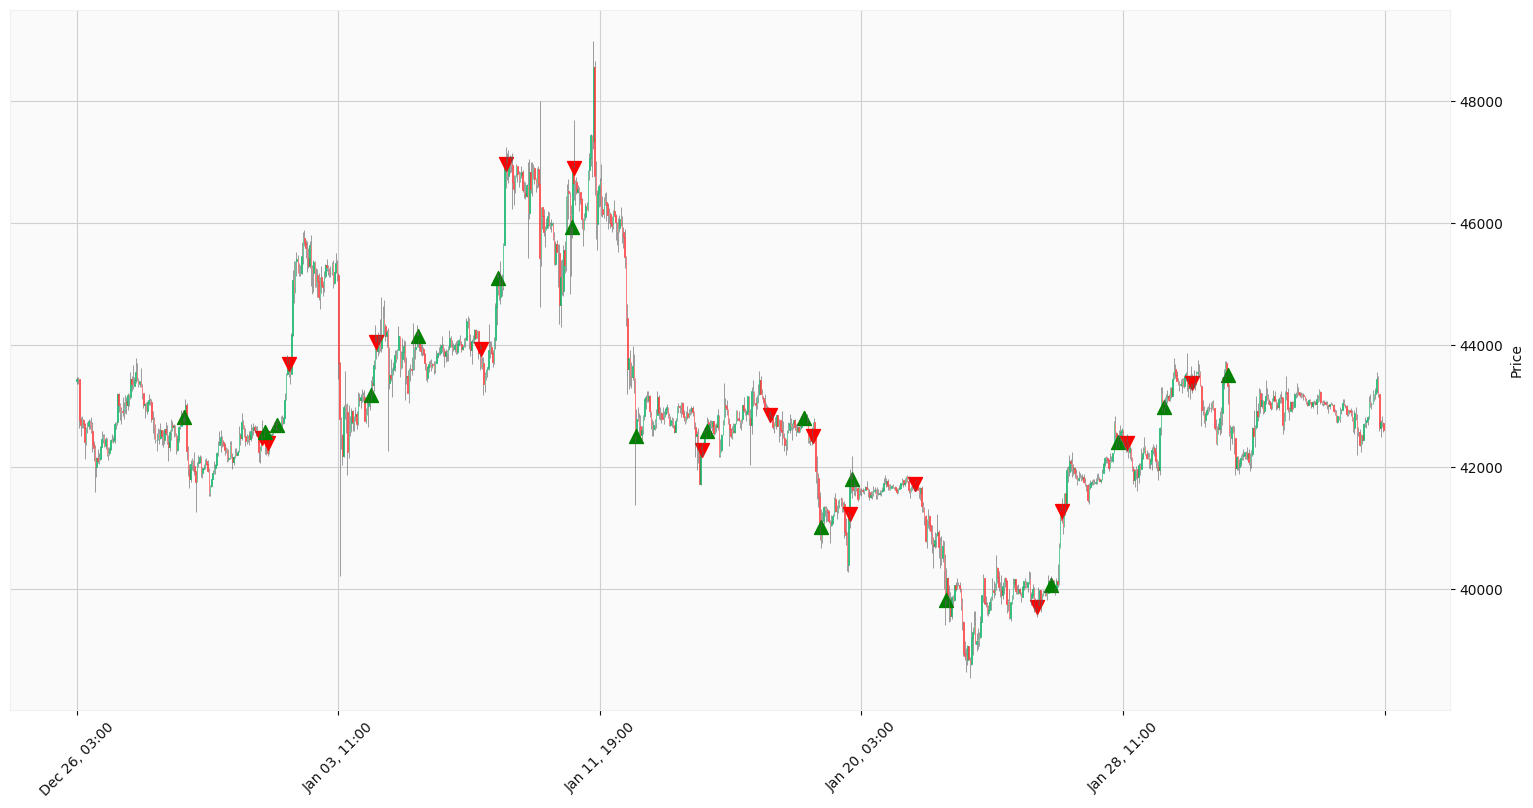

In [17]:
data = deepcopy(opt.data_60)
data.set_index('time', inplace=True)
data = pd.merge(data, buy, on='time', how='left')
data = pd.merge(data, sell, on='time', how='left')
sell_plot = mpf.make_addplot(data['sell_price'],type='scatter',markersize=100,marker='v',color="r")
buy_plot = mpf.make_addplot(data['buy_price'],type='scatter',markersize=100,marker='^',color="g")
mpf.plot(data, type = 'candle', style='yahoo', figsize=(20,10), addplot=[sell_plot, buy_plot])


In [10]:

def place_order(order_type, coin, crypto):

    session = HTTP(api_key=api_key, api_secret=secret, testnet=False)
    qty = 2*float(session.get_instruments_info(
    category="spot",
    symbol=coin,
        ).get('result').get('list')[0].get('lotSizeFilter').get('minOrderQty'))
    
    k = len(str(qty).split('.')[1].split('e')[0]) + int(str(qty)[-1])
    
    qty = f'{qty:.{k}f}'
  

    orderbook = session.get_orderbook(
        category="spot",
        symbol=coin, limit = 200).get('result')
    
    b_price = orderbook['a'][0][0]
    s_price = orderbook['b'][0][0]



    

    if order_type == 'Buy':
        order = session.place_order(category = 'spot', symbol = coin, side = order_type, qty = qty, orderType = "Limit", price = b_price)
        print(f"Long, price:{b_price}")
        print(order)

        return b_price
    
    if order_type == 'Sell':
        qty_sell = float(session.get_wallet_balance(
                accountType="UNIFIED",
                coin=crypto,
            ).get('result')['list'][0]['coin'][0]['availableToWithdraw'])
        
        qty_sell = math.floor(qty_sell * 10**k) / 10**k
        qty_sell = f'{qty_sell:.{k}f}'
        
        order = session.place_order(category = 'spot', symbol = coin, side = order_type, qty = qty_sell, orderType = "Limit", price = s_price)
        print("Short")
        print(order)
        
        return s_price

In [12]:
def main():
    buy = False
    sell = True
    start_time = int(time.time())
    print(f'Start {start_time}')
    i = 0
    

    i1 = 60
    i2 = 120
    coin = 'BTCUSDT'
    crypto = 'BTC'
    limit = 1000

    transactions = 0
    mistakes = 0

    candels_downloader_1h = get_candels(interval = i1, limit = limit , category = "spot", symbol = coin)
    candels_downloader_2h = get_candels(interval = i2, limit = limit , category = "spot", symbol = coin)
    while True:

        if i == 0:
            opt = optimization(intervals=[i1, i2], limit = limit , category = "spot", symbol = coin)
            opt.get_data()
            result = opt.optimize()
            best_params = result[0]
            best_fitness = result[1]
            i = 1
            print(f'Best params {best_params}')
            print('--------------------------')
            print(f'best fitness {best_fitness}')
            


        data_1h = candels_downloader_1h.getting_data()
        data_2h = candels_downloader_2h.getting_data()
        


        if best_params[f'fastperiod_{i1}'] < best_params[f'slowperiod_{i1}']:
            fastperiod_1h = best_params[f'fastperiod_{i1}']
            slowperiod_1h = best_params[f'slowperiod_{i1}']
        else:
            fastperiod_1h = best_params[f'slowperiod_{i1}']
            slowperiod_1h = best_params[f'fastperiod_{i1}']

        if best_params[f'fastperiod_{i2}'] < best_params[f'slowperiod_{i2}']:
            fastperiod_2h = best_params[f'fastperiod_{i2}']
            slowperiod_2h = best_params[f'slowperiod_{i2}']
        else:
            fastperiod_2h = best_params[f'slowperiod_{i2}']
            slowperiod_2h = best_params[f'fastperiod_{i2}']

        signalperiod_1h = best_params[f'signalperiod_{i2}']
        signalperiod_2h = best_params[f'signalperiod_{i2}']

        rsi_1h = best_params[f'rsi_{i1}']
        rsi_2h = best_params[f'rsi_{i2}']

        rsi_low = 30
        rsi_high = 70
        
        # # print(fastperiod_1h)
        # fastperiod_1h = 7
        # slowperiod_1h = 43
        # signalperiod_1h = 24
        # rsi_1h = 14
        
        indicators_1h = calculate_ta_indicators(data_1h, fastperiod=fastperiod_1h, slowperiod=slowperiod_1h, signalperiod=signalperiod_1h, rsi=rsi_1h)
        indicators_2h = calculate_ta_indicators(data_2h, fastperiod=fastperiod_2h, slowperiod=slowperiod_2h, signalperiod=signalperiod_2h, rsi=rsi_2h)

        small_period = united_dfs(data_1h, indicators_1h)
        small_period['macd_diff'] = small_period['macdhist'].diff()

        bigger_period = united_dfs(data_2h, indicators_2h)
        bigger_period['macd_diff'] = bigger_period['macdhist'].diff()
        bigger_period_i_1 = bigger_period.iloc[-2]
        bigger_period_i_2 = bigger_period.iloc[-1]

        points = 0 
        
        #small period
        if small_period['macdhist'].iloc[-3] < 0 and small_period['macdhist'].iloc[-2]> 0:
            points += 1
            # print(f"small_macd + {points}")
        elif small_period['macdhist'].iloc[-3] > 0 and small_period['macdhist'].iloc[-2] < 0:
            points -= 1
            # print(f"small_macd - {points}")

        if (small_period['rsi'].iloc[-1] <= rsi_low):
            points += 1
            # print(f"small_rsi + {points}")
        
        elif (small_period['rsi'].iloc[-1] >= rsi_high):
            points -= 1
            # print(f"small_rsi - {points}")

        if (small_period['macd_diff'].iloc[-3] > 0) and (small_period['macd_diff'].iloc[-2] < 0) and (small_period['macdhist'].iloc[-3] > 0) and (small_period['macdhist'].iloc[-2] > 0):
            points-= 1
            # print(f"small_macd_diff - {points}")
        
        elif (small_period['macd_diff'].iloc[-3] < 0) and (small_period['macd_diff'].iloc[-2] > 0) and (small_period['macdhist'].iloc[-3] < 0) and (small_period['macdhist'].iloc[-2] < 0):
            points+= 1
            # print(f"small_macd_diff + {points}")

        if (small_period['macdhist'].iloc[-3] <= small_period['macdhist'].iloc[-2]) and (small_period['macdhist'].iloc[-3] > 0) and (small_period['macdhist'].iloc[-2] > 0):
            points += 1
            # print(f"small macd_diff + exp : {points}")

        elif (small_period['macdhist'].iloc[-3] >= small_period['macdhist'].iloc[-2]) and (small_period['macdhist'].iloc[-3] < 0) and (small_period['macdhist'].iloc[-2] < 0):
            points += 1
            # print(f"small macd_diff + exp : {points}")
    

        # # bigger_period
        # if bigger_period_i_1['macdhist'] < 0 and bigger_period_i_1['macdhist'] > 0:
        #     points += 1
        # elif bigger_period_i_2['macdhist'] > 0 and bigger_period_i_2['macdhist'] < 0:
        #     points -= 1
        
        # if (bigger_period_i_1['rsi'] <= rsi_low):
        #     points += 1
        #     # print(f"big_rsi + {points}")
        # elif (bigger_period_i_1['rsi'] >= rsi_high):
        #     points -= 1
        #     # print(f"big_rsi - {points}")
        
        if (bigger_period_i_1['macd_diff'] > 0) and (bigger_period_i_2['macd_diff'] < 0) and (bigger_period_i_1['macdhist'] > 0) and (bigger_period_i_2['macdhist'] > 0):
            points-= 1
            # print(f"big_macd_diff - {points}")

        elif (bigger_period_i_1['macd_diff'] < 0) and (bigger_period_i_2['macd_diff'] > 0) and (bigger_period_i_1['macdhist'] < 0) and (bigger_period_i_2['macdhist'] < 0):
            points+= 1
            # print(f"big_macd_diff + {points}")
        
        if (bigger_period_i_1['macd_diff'] <= bigger_period_i_2['macd_diff']) and (bigger_period_i_1['macdhist'] > 0) and (bigger_period_i_2['macdhist'] > 0):
            points += 1
            # print(f"bigger macd_diff + exp : {points}")

        elif (bigger_period_i_1['macd_diff'] >= bigger_period_i_2['macd_diff']) and (bigger_period_i_1['macdhist'] < 0) and (bigger_period_i_2['macdhist'] < 0):
            points -= 1
            # print(f"bigger macd_diff - exp : {points}")

        session = HTTP(api_key=api_key, api_secret=secret, testnet=False)

        orderbook = session.get_orderbook(
        category="spot",
        symbol=coin, limit = 200).get('result')

        # ask_p = np.array(list(map(float, np.array(orderbook['a'])[:,0])))
        # ask_qty = np.array(list(map(float, np.array(orderbook['a'])[:,1])))
        # ask = np.sum(ask_p*ask_qty)

        # bid_p = np.array(list(map(float, np.array(orderbook['b'])[:,0])))
        # bid_qty = np.array(list(map(float, np.array(orderbook['b'])[:,1])))
        # bid = np.sum(bid_p*bid_qty)

        # if (ask - bid) > 0 and sell:

        #     points += 1
        #     # print(f"ask > bid на {(ask - bid)/ask *100}%")
        # elif (ask - bid) < 0 and buy:
        #     points -= 1
        #     # print(f"ask < bid на {(ask - bid)/ask *100}%")


        





        if buy:

            # orderbook = session.get_orderbook(
            # category="spot",
            # symbol=coin, limit = 1).get('result')

            s_price = float(orderbook['b'][0][0])
            condition = (s_price - b_price - (s_price + b_price) * 0.001)/b_price

            if condition > 0:
                points -= 1
                print(f"condition - {points}")
        #     elif condition > 0:

        #         if (small_period['macd_diff'].iloc[-2]) < 0 and (small_period['macd_diff'].iloc[-3] > 0) and (small_period['macdhist'].iloc[-2] > 0) and (small_period['macdhist'].iloc[-3] > 0):
        #             points -= 1
        #             # print(f"macd_diff - {points}")

        # if (small_period['macd_diff'].iloc[-3] < 0) and (small_period['macd_diff'].iloc[-2] > 0) and (small_period['macdhist'].iloc[-2] < 0) and (small_period['macdhist'].iloc[-3] < 0):
        #     points+= 1
        #     # print(f"macd_diff + {points}")


        # if small_period['rsi'].iloc[-1]<= 30:
        #     points += 1

        #     # print(f"RSI + {points}")
        # elif small_period['rsi'].iloc[-1] >= 70:
        #     points -= 1
        #     # print(f"RSI - {points}")
        
        # if bigger_period_data_i['macdhist'] < 0 and bigger_period_data_i_1['macdhist'] > 0:
        #     points += 1
        # elif bigger_period_data_i['macdhist'] > 0 and bigger_period_data_i_1['macdhist'] < 0:
        #     points -= 1
        
        # if bigger_period_data_i['rsi'] <= 30:
        #     points += 1
        # elif bigger_period_data_i['rsi'] >= 70:
        #     points -= 1
        # session = HTTP(api_key=api_key, api_secret=secret, testnet=False)

        # availible_coins = float(session.get_wallet_balance(
        #         accountType="UNIFIED",
        #         coin=crypto,
        #     ).get('result')['list'][0]['coin'][0]['availableToWithdraw'])
        
        # min_qty = float(session.get_instruments_info(
        #             category="spot",
        #             symbol=coin,
        #         ).get('result').get('list')[0].get('lotSizeFilter').get('minOrderQty'))
        
        # if (points > 0) and (availible_coins < min_qty):
        
        if (points > 0) and (not buy):
            print(f"Points: {points} time: {small_period['time'].iloc[-1]}")
            b_price = float(place_order('Buy', coin, crypto))
            print(f"Buy price: {b_price}")
            buy = not buy
            sell = not sell
        
        # if points < 0 and (availible_coins > 0):
        if (points < 0) and (not sell):
            print(f"Points: {points} time: {small_period['time'].iloc[-1]}")

            s_price = place_order('Sell', coin, crypto)
            print(f"Sell price: {s_price}")
            buy = not buy
            sell = not sell 

            revenue = (float(s_price) - float(b_price) - (float(b_price) + float(s_price))* 0.001)/float(b_price) * 100

            print(f"Прибыль: {revenue}%")
            transactions+= 1
            if revenue < 0:
                mistakes += 1
            
            print(f"transactions/mistakes: {transactions}/{mistakes}")

            if mistakes/transactions >= 0.5 and transactions >= 5:
                opt = optimization(intervals=[i1, i2], limit = limit , category = "spot", symbol = coin)
                opt.get_data()
                result = opt.optimize()
                best_params = result[0]
                print("Optimizing...")
                print(f'Best params {best_params}')
                print('--------------------------')
                print(f'best fitness {best_fitness}')
                mistakes = 0
                transactions = 0
        
        # current_time = time.time()

        # if start_time - current_time % 600 == 0:
        #     opt = optimization(interval_1 = i1, interval_2 = i2, limit = limit , category = "spot", symbol = coin)
        #     opt.get_data()
        #     best_params = opt.optimize()
        

        if buy:
            time.sleep(5)
        else:
            time.sleep(60)

        


In [13]:
if __name__ == '__main__':
    main()

Start 1705355554
Best params {'fastperiod_60': 27, 'slowperiod_60': 15, 'signalperiod_60': 25, 'fastperiod_120': 29, 'slowperiod_120': 29, 'signalperiod_120': 23, 'rsi_60': 30, 'rsi_120': 4}
--------------------------
best fitness -2.8082786199999537
Points: 1 time: 2024-01-15 21:00:00
Long, price:42770.32
{'retCode': 0, 'retMsg': 'OK', 'result': {'orderId': '1599035097905108224', 'orderLinkId': '1599035097905108225'}, 'retExtInfo': {}, 'time': 1705355837988}
Buy price: 42770.32
Points: -1 time: 2024-01-15 22:00:00
Short
{'retCode': 0, 'retMsg': 'OK', 'result': {'orderId': '1599036644495987968', 'orderLinkId': '1599036644495987969'}, 'retExtInfo': {}, 'time': 1705356022355}
Sell price: 42727.99
Прибыль: -0.29887153053800336%
transactions/mistakes: 1/1
Points: 1 time: 2024-01-16 03:00:00


2024-01-16 06:00:58 - pybit._http_manager - ERROR - Timestamp for this request is outside of the recvWindow. (ErrCode: 10002). Added 2.5 seconds to recv_window. 2 retries remain.
2024-01-16 06:00:58 - pybit._http_manager - ERROR - Timestamp for this request is outside of the recvWindow. (ErrCode: 10002). Added 2.5 seconds to recv_window. 2 retries remain.
2024-01-16 06:00:58 - pybit._http_manager - ERROR - Timestamp for this request is outside of the recvWindow. (ErrCode: 10002). Added 2.5 seconds to recv_window. 2 retries remain.
2024-01-16 06:00:58 - pybit._http_manager - ERROR - Timestamp for this request is outside of the recvWindow. (ErrCode: 10002). Added 2.5 seconds to recv_window. 2 retries remain.
2024-01-16 06:00:58 - pybit._http_manager - ERROR - Timestamp for this request is outside of the recvWindow. (ErrCode: 10002). Added 2.5 seconds to recv_window. 2 retries remain.
2024-01-16 06:00:58 - pybit._http_manager - ERROR - Timestamp for this request is outside of the recvWind

Long, price:42716.72
{'retCode': 0, 'retMsg': 'OK', 'result': {'orderId': '1599187959851259136', 'orderLinkId': '1599187959851259137'}, 'retExtInfo': {}, 'time': 1705374060552}
Buy price: 42716.72
Points: -1 time: 2024-01-16 06:00:00


2024-01-16 09:00:07 - pybit._http_manager - ERROR - invalid request, please check your server timestamp or recv_window param. req_timestamp[1705384807620],server_timestamp[1705384806063],recv_window[5000] (ErrCode: 10002). Added 2.5 seconds to recv_window. 2 retries remain.
2024-01-16 09:00:07 - pybit._http_manager - ERROR - invalid request, please check your server timestamp or recv_window param. req_timestamp[1705384807620],server_timestamp[1705384806063],recv_window[5000] (ErrCode: 10002). Added 2.5 seconds to recv_window. 2 retries remain.
2024-01-16 09:00:07 - pybit._http_manager - ERROR - invalid request, please check your server timestamp or recv_window param. req_timestamp[1705384807620],server_timestamp[1705384806063],recv_window[5000] (ErrCode: 10002). Added 2.5 seconds to recv_window. 2 retries remain.
2024-01-16 09:00:07 - pybit._http_manager - ERROR - invalid request, please check your server timestamp or recv_window param. req_timestamp[1705384807620],server_timestamp[170

FailedRequestError: Bad request. retries exceeded maximum. (ErrCode: 400) (ErrTime: 06:00:22).
Request → GET https://api.bybit.com/v5/account/wallet-balance: accountType=UNIFIED&coin=BTC.